In [ ]:
#사진자료 전처리
import os
import tensorflow as tf
import shutil

os.mkdir('/content/dataset/')    #폴더 만들기
os.mkdir('/content/dataset/fire/') 

for i in os.listdir('/content/train/'):
  if 'fire' in i:
    shutil.copyfile( '/content/train/'+i , '/content/dataset/fire/' + i)
  if 'other' in i:
    shutil.copyfile( '/content/train/'+i , '/content/dataset/other/' + i)

Found 318 files belonging to 4 classes.
Using 255 files for training.
Found 318 files belonging to 4 classes.
Using 63 files for validation.
tf.Tensor(
[[[[9.2549020e-01 9.0588236e-01 8.9019608e-01]
   [9.2461014e-01 9.0500230e-01 8.8931602e-01]
   [9.1869223e-01 8.9908439e-01 8.8339812e-01]
   ...
   [3.9215689e-03 3.9215689e-03 3.9215689e-03]
   [3.9215689e-03 3.9215689e-03 3.9215689e-03]
   [1.3361751e-03 1.3361751e-03 1.3361751e-03]]

  [[9.2549020e-01 9.0588236e-01 8.9019608e-01]
   [9.2461014e-01 9.0500230e-01 8.8931602e-01]
   [9.2102826e-01 9.0142035e-01 8.8573408e-01]
   ...
   [3.9215689e-03 3.9215689e-03 3.9215689e-03]
   [3.9215689e-03 3.9215689e-03 3.9215689e-03]
   [3.9215689e-03 3.9215689e-03 3.9215689e-03]]

  [[9.3112552e-01 9.1151768e-01 8.9583141e-01]
   [9.3024552e-01 9.1063768e-01 8.9495140e-01]
   [9.2573720e-01 9.0612936e-01 8.9044309e-01]
   ...
   [1.3820387e-03 1.3820387e-03 1.3820387e-03]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000

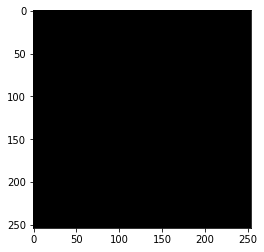

In [7]:
import os
import tensorflow as tf

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/dataset/',
    image_size = (254, 254),
    batch_size = 64,         
    subset = 'training',
    validation_split = 0.2,  
    seed = 1234              
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/dataset/',
    image_size = (254, 254),   
    batch_size = 64,         
    subset = 'validation',
    validation_split = 0.2,
    seed = 1234
)

def pre_func(i, 정답):
  i = tf.cast(i / 255.0, tf.float32)      # i를 전부 255로 나눠줌
  return i, 정답

# 0~1사이로 압축해주면 계산하는 양이 작아짐 근데 크게 차이는 안남

train_ds = train_ds.map(pre_func)
val_ds = val_ds.map(pre_func)

import matplotlib.pyplot as plt

 #미리보기 답이랑 사진

for i, 정답 in train_ds.take(1):
  print(i)
  print(정답)
  plt.imshow(i[0].numpy().astype('uint8') )
  plt.show()

In [8]:
import requests

url = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
r = requests.get(url, allow_redirects=True)

open('inception_v3.h5', 'wb').write(r.content)

87910968

In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception_model = InceptionV3( input_shape =(254,254,3), include_top=False, weights=None)
inception_model.load_weights('inception_v3.h5')

for i in inception_model.layers:
  i.trainable = False

unfreeze = False
for i in inception_model.layers:
  if i.name == 'mixed6':
    unfreeze = True
  if unfreeze == True:
    i.trainable = True

last_layer = inception_model.get_layer('mixed7')
print(last_layer)
print(last_layer.output)
print(last_layer.output_shape)

KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")
(None, 14, 14, 768)


In [14]:
import tensorflow as tf

layer1 = tf.keras.layers.Flatten()(last_layer.output)
layer2 = tf.keras.layers.Dense(1024, activation='relu')(layer1)
drop1 = tf.keras.layers.Dropout(0.2)(layer2)
layer3 = tf.keras.layers.Dense(10, activation='softmax')(drop1)

model = tf.keras.Model(inception_model.input, layer3)

callback_func = tf.keras.callbacks.ModelCheckpoint(
    filepath='ckpt/mnist',
    monitor = 'val_acc',
    mode='max',
    save_weights_only = True,
    save_freq = 'epoch'
)


In [23]:
import tensorflow as tf

layer1 = tf.keras.layers.Flatten()(last_layer.output)
layer2 = tf.keras.layers.Dense(1024, activation='relu')(layer1)
drop1 = tf.keras.layers.Dropout(0.2)(layer2)
layer3 = tf.keras.layers.Dense(10, activation='softmax')(drop1)

model = tf.keras.Model(inception_model.input, layer3)

callback_func = tf.keras.callbacks.ModelCheckpoint(
    filepath='ckpt/mnist',
    monitor = 'val_acc',
    mode='max',
    save_weights_only = True,
    save_freq = 'epoch'
)

model.compile(loss = 'sparse_categorical_crossentropy',optimizer='adam',metrics=['acc'])
model.fit(train_ds, validation_data=val_ds, epochs=2, callbacks=[callback_func])

Epoch 1/2
4/4 [==============================] - 39s 1s/step - loss: 0.5476 - acc: 0.8039 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/2
4/4 [==============================] - 2s 328ms/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000


In [16]:
callback_func = tf.keras.callbacks.ModelCheckpoint(
    filepath='ckpt/mnist',
    monitor = 'val_acc',
    mode='max',
    save_weights_only = True,
    save_freq = 'epoch'
)

In [22]:
callback_func = tf.keras.callbacks.ModelCheckpoint(
    filepath='ckpt/mnist',
    monitor = 'val_acc',
    mode='max',
    save_weights_only = True,
    save_freq = 'epoch'
)


model.compile(loss = 'sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(lr=0.00001),metrics=['acc'])
model.fit(train_ds, validation_data+val_ds, epochs=2, callbacks=[callback_func])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


NameError: ignored

In [24]:
model.save('/content/')

INFO:tensorflow:Assets written to: /content/assets


In [25]:
model.save("my_h5_model.h5")